# **TDS Project: Part 2 - Advanced Model Analysis, Optimization, and Conclusions**
**Group Members:**

- Adir Elmakais - 316413640

## **Installation Guide**

#### Use Python 3.12.0

To get started with the project, ensure you are using **Python 3.12.0**.

1. **Install Python 3.12.0**:
   - Download the installer for Python 3.12.0 from the [official Python website](https://www.python.org/downloads/release/python-3120/).
   - During the installation, make sure to check the box **"Add Python to PATH"**.

2. **macOS: Install `libomp`**:
   - For macOS users, you need to install `libomp` for compatibility with XGBoost. Run the following command:
     ```bash
     brew install libomp
     ```

3. **Install Required Packages**:
   - Once Python 3.12.0 is installed, you can install the necessary packages listed in the `requirements.txt` file by running the following command in your terminal:
     ```bash
     pip install -r requirements.txt
     ```

## **Introduction**
In the second part of the TDS Project, we aim to enhance our initial machine learning pipeline by addressing the weaknesses identified during error analysis. This involves optimizing the model through hyperparameter tuning, feature engineering, and other advanced techniques to improve its predictive performance. Subsequently, we'll analyze the improved model, compare it with the baseline, and draw meaningful conclusions from our findings.



## Loading the Baseline Model and Data
We'll begin by loading the cleaned dataset and the baseline model saved in Part 1. This will allow us to build upon the existing pipeline and apply further optimizations.

In [39]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# Setting plot styles
sns.set_theme(style="whitegrid")
%matplotlib inline

# Paths to the cleaned data and the baseline model
cleaned_data_path = os.path.join('data', 'StudentPerformaceFactorsClean.csv')
model_path = os.path.join('models', 'pipeline_model.joblib')

# Loading the cleaned dataset
data_cleaned = pd.read_csv(cleaned_data_path)
print("Cleaned dataset loaded successfully.")

# Loading the baseline model
pipeline = joblib.load(model_path)
print("Baseline model loaded successfully.")


Cleaned dataset loaded successfully.
Baseline model loaded successfully.


1. **Error Analysis Conclusions & Work Plan**
   
   - **Residual Distribution**
     - **Observation**: Slight heteroscedasticity observed in residuals, with increased variance for higher predicted scores.
     - **Action**: Investigate transformations of the target variable or features to stabilize variance.
   
   - **Subgroup Performance**
     - **Observation**: Lower performance for students with Low and High parental involvement levels.
     - **Action**: Explore interactions between parental involvement and other features or incorporate additional relevant features.
   
   - **Feature Importance**
     - **Observation**: Attendance, Hours_Studied, and Previous_Scores are significant predictors, but other features may also play crucial roles.
     - **Action**: Conduct feature engineering to create new features or transform existing ones to capture more information.
   
   - **Bias in Predictions**
     - **Observation**: Slight tendency towards underestimation in predictions.
     - **Action**: Adjust the model to reduce bias, possibly by addressing data imbalance or refining the loss function.
   
   - **Outliers**
     - **Observation**: Presence of outliers affecting model performance.
     - **Action**: Implement robust scaling or outlier detection methods to mitigate their impact.
   
2. **Work Plan**
   
   - **Hyperparameter Tuning**: Optimize XGBoost parameters to enhance model performance.
   - **Feature Engineering**: Create new features and transform existing ones based on domain knowledge and EDA insights.
   - **Handling Outliers**: Apply techniques to detect and handle outliers effectively.
   - **Data Balancing**: If applicable, ensure that the model is not biased towards certain subgroups by balancing the data.


## 2. **Improving Model Performance**

### a. Hyperparameter Tuning

Hyperparameter tuning involves adjusting the model’s parameters to find the optimal configuration that minimizes error and maximizes performance. We’ll use GridSearchCV to perform an exhaustive search over specified parameter values for the XGBoost regressor.

**Step-by-Step Implementation:**
1. **Define Features and Target**
2. **Identify Categorical and Numerical Features**
3. **Handle Categorical Data**
4. **Perform Train-Test Split**
5. **Set Up and Run GridSearchCV**
6. **Save the Improved Model**

**Step 1: Define Features and Target**

In [40]:
# Define features and target
X = data_cleaned.drop('Exam_Score', axis=1)
y = data_cleaned['Exam_Score']

**Step 2: Identify Categorical and Numerical Features**

In [41]:
# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

**Step 3: Handle Categorical Data**

Convert boolean columns to integers if any exist. This ensures compatibility with machine learning models.

In [42]:
# Convert boolean columns to integers if any
for col in categorical_features:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)

**Step 4: Perform Train-Test Split**

Split the data into training and testing sets to evaluate model performance effectively.

In [43]:
from sklearn.model_selection import train_test_split

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 5102 samples
Testing set size: 1276 samples


**Step 5: Set Up and Run GridSearchCV**

Define the parameter grid for XGBoost and initialize GridSearchCV to perform hyperparameter tuning.

In [44]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for XGBoost
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.7, 0.8, 0.9],
    'model__colsample_bytree': [0.7, 0.8, 0.9]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

Explanation:
- **Parameter Grid (param_grid)**: Specifies the combinations of hyperparameters to search over.
  - model__n_estimators: Number of boosting rounds. Higher values can improve performance but may increase training time.
  - model__max_depth: Maximum depth of a tree. Controls the complexity of the model; deeper trees can capture more information but may overfit.
  - model__learning_rate: Step size shrinkage used in update to prevent overfitting. Smaller values make the model more robust but require more boosting rounds.
  - model__subsample: Subsample ratio of the training instances. Prevents overfitting by sampling a fraction of the training data.
  - model__colsample_bytree: Subsample ratio of columns when constructing each tree. Helps in reducing overfitting by sampling a fraction of features.
  
- **GridSearchCV Initialization**:
  - estimator: The pipeline loaded from Part 1.
  - param_grid: The grid of hyperparameters.
  - cv: Number of cross-validation folds.
  - scoring: Metric to evaluate model performance (r2 in this case).
  - verbose: Controls the verbosity level.
  - n_jobs: Number of jobs to run in parallel (-1 uses all processors).

**Fitting GridSearchCV:**

In [45]:
# Fit GridSearchCV
print("Starting hyperparameter tuning...")
grid_search.fit(X_train, y_train)
print("Hyperparameter tuning completed.")

Starting hyperparameter tuning...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Hyperparameter tuning completed.


**Retrieve Best Parameters and Score:**

In [46]:
# Best parameters
print("Best Parameters:")
print(grid_search.best_params_)

# Best R2 Score
print(f"Best R² Score from GridSearchCV: {grid_search.best_score_:.4f}")

Best Parameters:
{'model__colsample_bytree': 0.7, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__subsample': 0.7}
Best R² Score from GridSearchCV: 0.6978


**Update Pipeline with Best Estimator:**

In [47]:
# Update the pipeline with best parameters
best_pipeline = grid_search.best_estimator_

**Save the Improved Model:**

In [48]:
# Save the improved model
improved_model_path = os.path.join('models', 'improved_model_after_ht.joblib')
joblib.dump(best_pipeline, improved_model_path)
print(f"Improved model saved at '{improved_model_path}'.")

Improved model saved at 'models/improved_model_after_ht.joblib'.


## **b. Feature Engineering**

Enhancing the dataset through feature engineering can capture additional patterns and relationships, potentially improving model performance.

### 1. Creating Interaction Features
Interaction features can capture the combined effect of two or more features on the target variable.

In [49]:
# Perform feature engineering on the training set

# Interaction between Hours_Studied and Motivation_Level
X_train['Hours_Motivation_Interaction'] = X_train['Hours_Studied'] * X_train['Motivation_Level'].map({'Low': 1, 'Medium': 2, 'High': 3})
X_test['Hours_Motivation_Interaction'] = X_test['Hours_Studied'] * X_test['Motivation_Level'].map({'Low': 1, 'Medium': 2, 'High': 3})

# Interaction between Attendance and Parental_Involvement
X_train['Attendance_Parental_Interaction'] = X_train['Attendance'] * X_train['Parental_Involvement'].map({'Low': 1, 'Medium': 2, 'High': 3})
X_test['Attendance_Parental_Interaction'] = X_test['Attendance'] * X_test['Parental_Involvement'].map({'Low': 1, 'Medium': 2, 'High': 3})

### 2. Transforming Existing Features
Applying transformations can help stabilize variance and make patterns more linear, which is beneficial for regression models.

In [50]:
# Log transformation of Previous_Scores to reduce skewness
log_offset = 1  # Handle zero values
X_train['Log_Previous_Scores'] = np.log1p(X_train['Previous_Scores'] + log_offset)
X_test['Log_Previous_Scores'] = np.log1p(X_test['Previous_Scores'] + log_offset)

# Polynomial Features for Hours_Studied
X_train['Hours_Studied_Squared'] = X_train['Hours_Studied'] ** 2
X_test['Hours_Studied_Squared'] = X_test['Hours_Studied'] ** 2

### 3. Encoding Categorical Features with Ordinal Encoding
For ordinal categorical features, ordinal encoding can preserve the order.

In [51]:
from sklearn.preprocessing import OrdinalEncoder

# Define ordinal features and their order
ordinal_features = {
    'Parental_Involvement': ['Low', 'Medium', 'High'],
    'Access_to_Resources': ['Low', 'Medium', 'High'],
    'Motivation_Level': ['Low', 'Medium', 'High'],
    'Teacher_Quality': ['Low', 'Medium', 'High'],
    'Peer_Influence': ['Negative', 'Neutral', 'Positive'],
    'Parental_Education_Level': ['High School', 'College', 'Postgraduate'],
    'Distance_from_Home': ['Near', 'Moderate', 'Far']
}

# Apply ordinal encoding
for feature, order in ordinal_features.items():
    ordinal_encoder = OrdinalEncoder(categories=[order])
    X_train[f'{feature}_Encoded'] = ordinal_encoder.fit_transform(X_train[[feature]])
    X_test[f'{feature}_Encoded'] = ordinal_encoder.transform(X_test[[feature]])

# Drop the original ordinal features after encoding
X_train.drop(columns=ordinal_features.keys(), inplace=True)
X_test.drop(columns=ordinal_features.keys(), inplace=True)

### 4. Updating Features in the Pipeline

In [52]:
import xgboost as xgb

# Exclude the original categorical features that have been encoded
categorical_features = [feature for feature in X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist() if feature not in ordinal_features.keys()]

# List of ordinal encoded features
ordinal_encoded_features = [f"{feature}_Encoded" for feature in ordinal_features.keys()]

# List of numerical features (including engineered numerical features)
numeric_features = [feature for feature in X.select_dtypes(include=[np.number]).columns.tolist() if feature not in ordinal_encoded_features]
numeric_features += ['Hours_Motivation_Interaction', 'Attendance_Parental_Interaction', 'Log_Previous_Scores', 'Hours_Studied_Squared']

# Update preprocessor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('ordinal', 'passthrough', ordinal_encoded_features)
    ],
    remainder='passthrough'  # Leave numeric features as is
)

best_params = grid_search.best_params_

model_params = {key.replace('model__', ''): value for key, value in best_params.items()}

# Update the pipeline with the new preprocessor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(**model_params, random_state=42))
])

# Fit the pipeline
print("Fitting the pipeline...")
pipeline.fit(X_train, y_train)
print("Pipeline fit completed.")

# Save updated pipeline
joblib.dump(pipeline, 'models/improved_model_after_ht_and_fe.joblib')
print("Updated preprocessor saved successfully.")


Fitting the pipeline...
Pipeline fit completed.
Updated preprocessor saved successfully.


### 5. Model Evaluation Metrics

In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Making predictions with the improved model
y_pred_improved = pipeline.predict(X_test)

# Calculating evaluation metrics for the improved model
mae_improved = mean_absolute_error(y_test, y_pred_improved)
mse_improved = mean_squared_error(y_test, y_pred_improved)
rmse_improved = np.sqrt(mse_improved)
r2_improved = r2_score(y_test, y_pred_improved)

print("Improved Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae_improved:.2f}")
print(f"Mean Squared Error (MSE): {mse_improved:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_improved:.2f}")
print(f"R² Score: {r2_improved:.2f}")


Improved Model Performance Metrics:
Mean Absolute Error (MAE): 0.68
Mean Squared Error (MSE): 4.50
Root Mean Squared Error (RMSE): 2.12
R² Score: 0.71


## **C. Detecting and Handling Outliers**

Outliers can skew the model’s understanding of the data, leading to biased predictions. It’s essential to identify and handle them appropriately.

### 1. Visualizing Outliers

    Box Plot: A straightforward method to visualize outliers in numerical features.

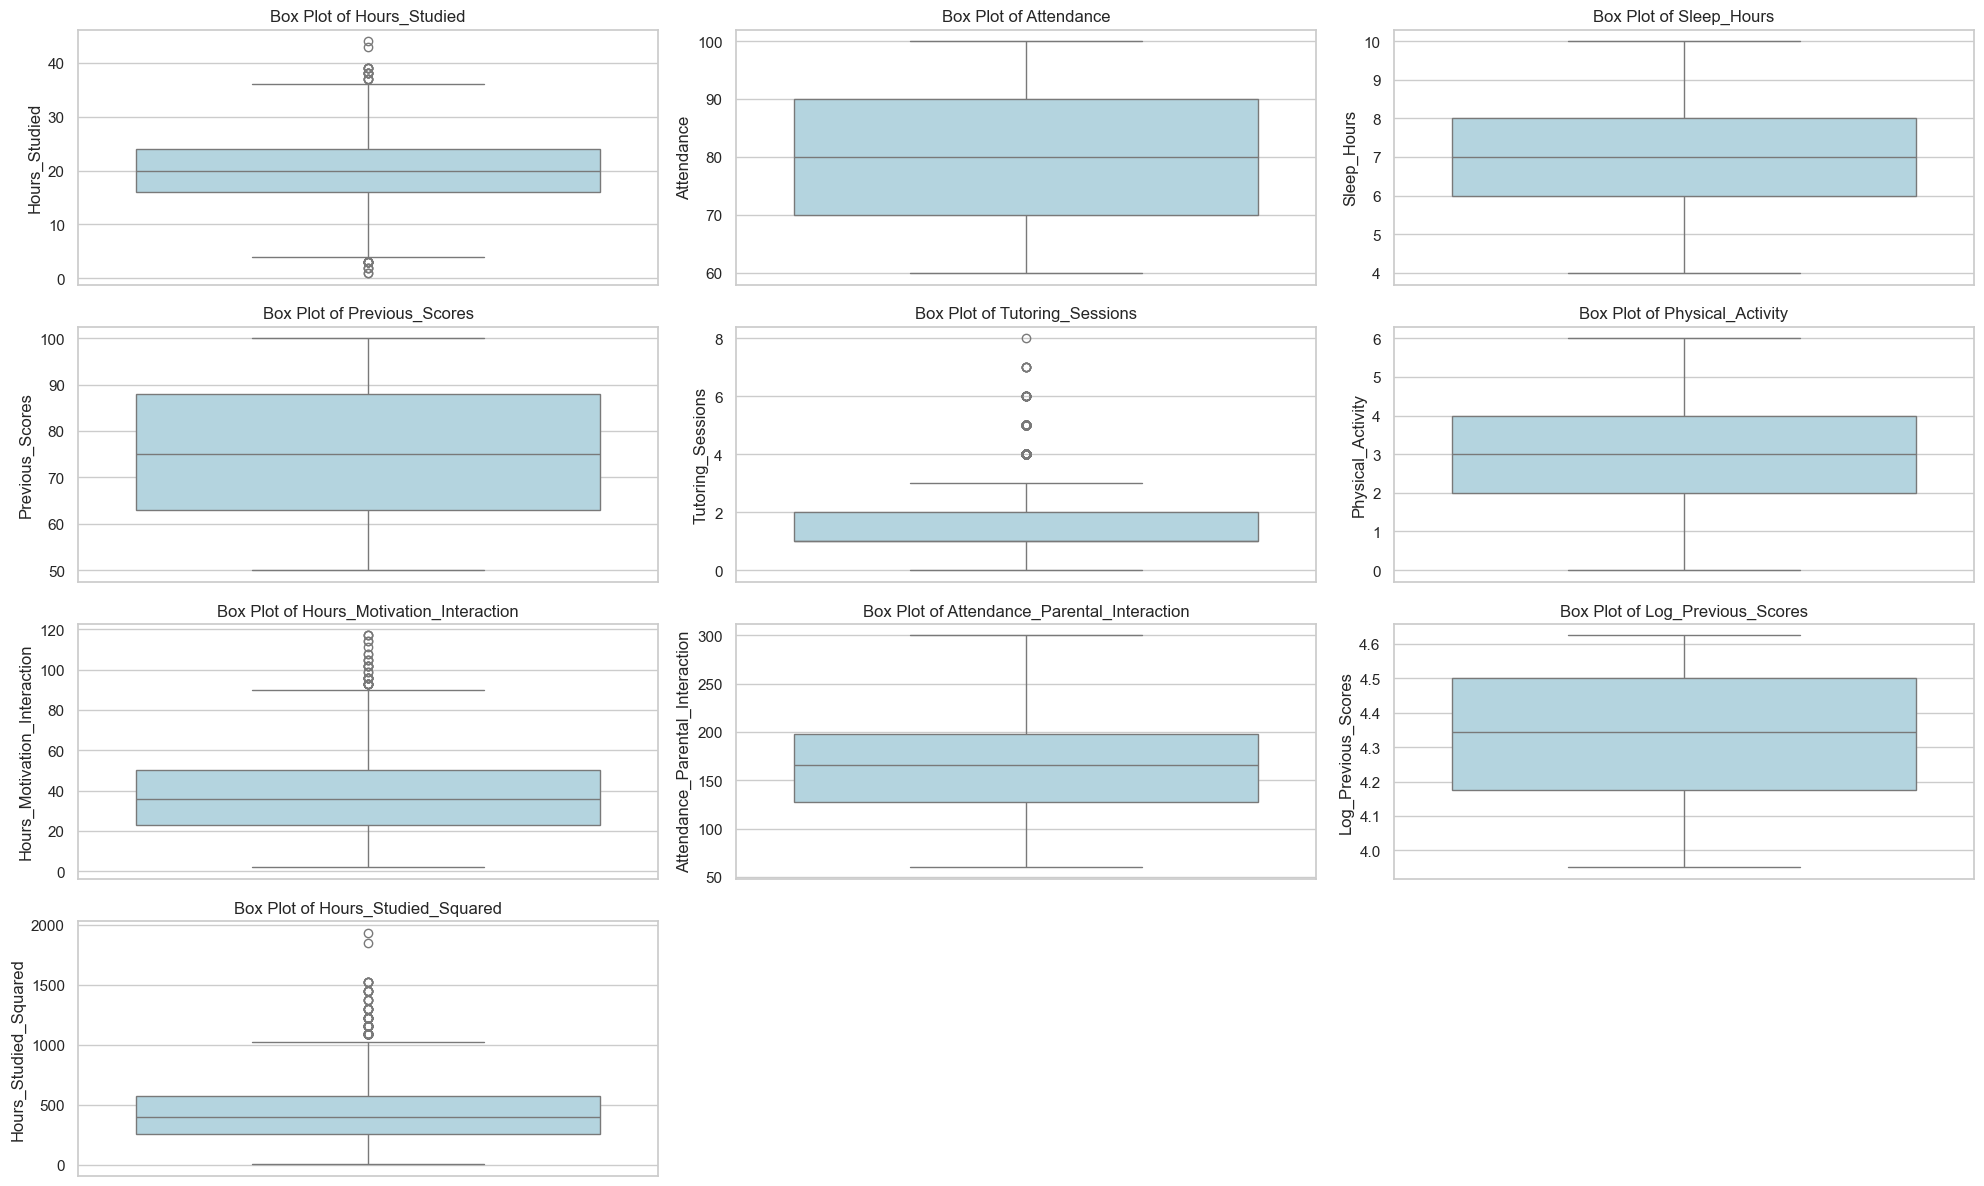

In [60]:
# Plotting box plots for numerical features
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(5, 3, i)
    sns.boxplot(y=X_train[feature], color='lightblue')
    plt.title(f'Box Plot of {feature}')
plt.tight_layout()
plt.show()

#### Interpretation:

- **Whiskers**: Represent the range within **1.5 * IQR** (Interquartile Range) from the lower and upper quartiles.
- **Points Outside Whiskers**: Considered **outliers**.

### 2. Z-Score Method:

Identifies outliers based on the number of standard deviations from the mean.

In [61]:
from scipy import stats

# Calculating Z-scores for numerical features
z_scores = np.abs(stats.zscore(X_train[numeric_features]))
threshold = 3  # Common threshold

# Identifying rows with any feature's Z-score above the threshold
outliers = (z_scores > threshold).any(axis=1)
print(f"Number of outliers detected: {outliers.sum()}")

# Displaying some outlier examples
print("Outlier Samples:\n", X_train[outliers].head())

Number of outliers detected: 83
Outlier Samples:
       Hours_Studied  Attendance Extracurricular_Activities  Sleep_Hours  \
931              31          67                         No            7   
3630             32          61                        Yes            7   
6263             35          84                        Yes            8   
734              35          65                        Yes            7   
2226             39          92                         No            9   

      Previous_Scores Internet_Access  Tutoring_Sessions Family_Income  \
931                92             Yes                  2        Medium   
3630               69             Yes                  0          High   
6263               92             Yes                  6           Low   
734                84             Yes                  0        Medium   
2226               73             Yes                  1        Medium   

     School_Type  Physical_Activity  ... Attendance_Pa

### 3. Handling Outliers

#### Options:
1. **Removal**: Delete the outlier rows.
2. **Capping (Winsorization)**: Limit extreme values to a certain percentile.
3. **Transformation**: Apply mathematical transformations to reduce the effect of outliers.

We'll perform **Capping**

In [62]:
# Function to cap outliers using IQR
def cap_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[feature] = np.where(df[feature] < lower_bound, lower_bound,
                           np.where(df[feature] > upper_bound, upper_bound, df[feature]))
    return df

# Applying capping to numerical features
for feature in numeric_features:
    X_train = cap_outliers(X_train, feature)
    X_test = cap_outliers(X_test, feature)

print("Outliers have been capped using the IQR method.")

Outliers have been capped using the IQR method.


#### Explanation:
- **IQR Method**: Caps the values at the lower and upper bounds defined by *1.5 × IQR* below **Q1** and above **Q3**.
- **Preservation**: Unlike removal, capping retains all data points, merely limiting extreme values.

### 4. Verifying Outlier Handling
Let’s visualize the box plots again to ensure outliers have been addressed.

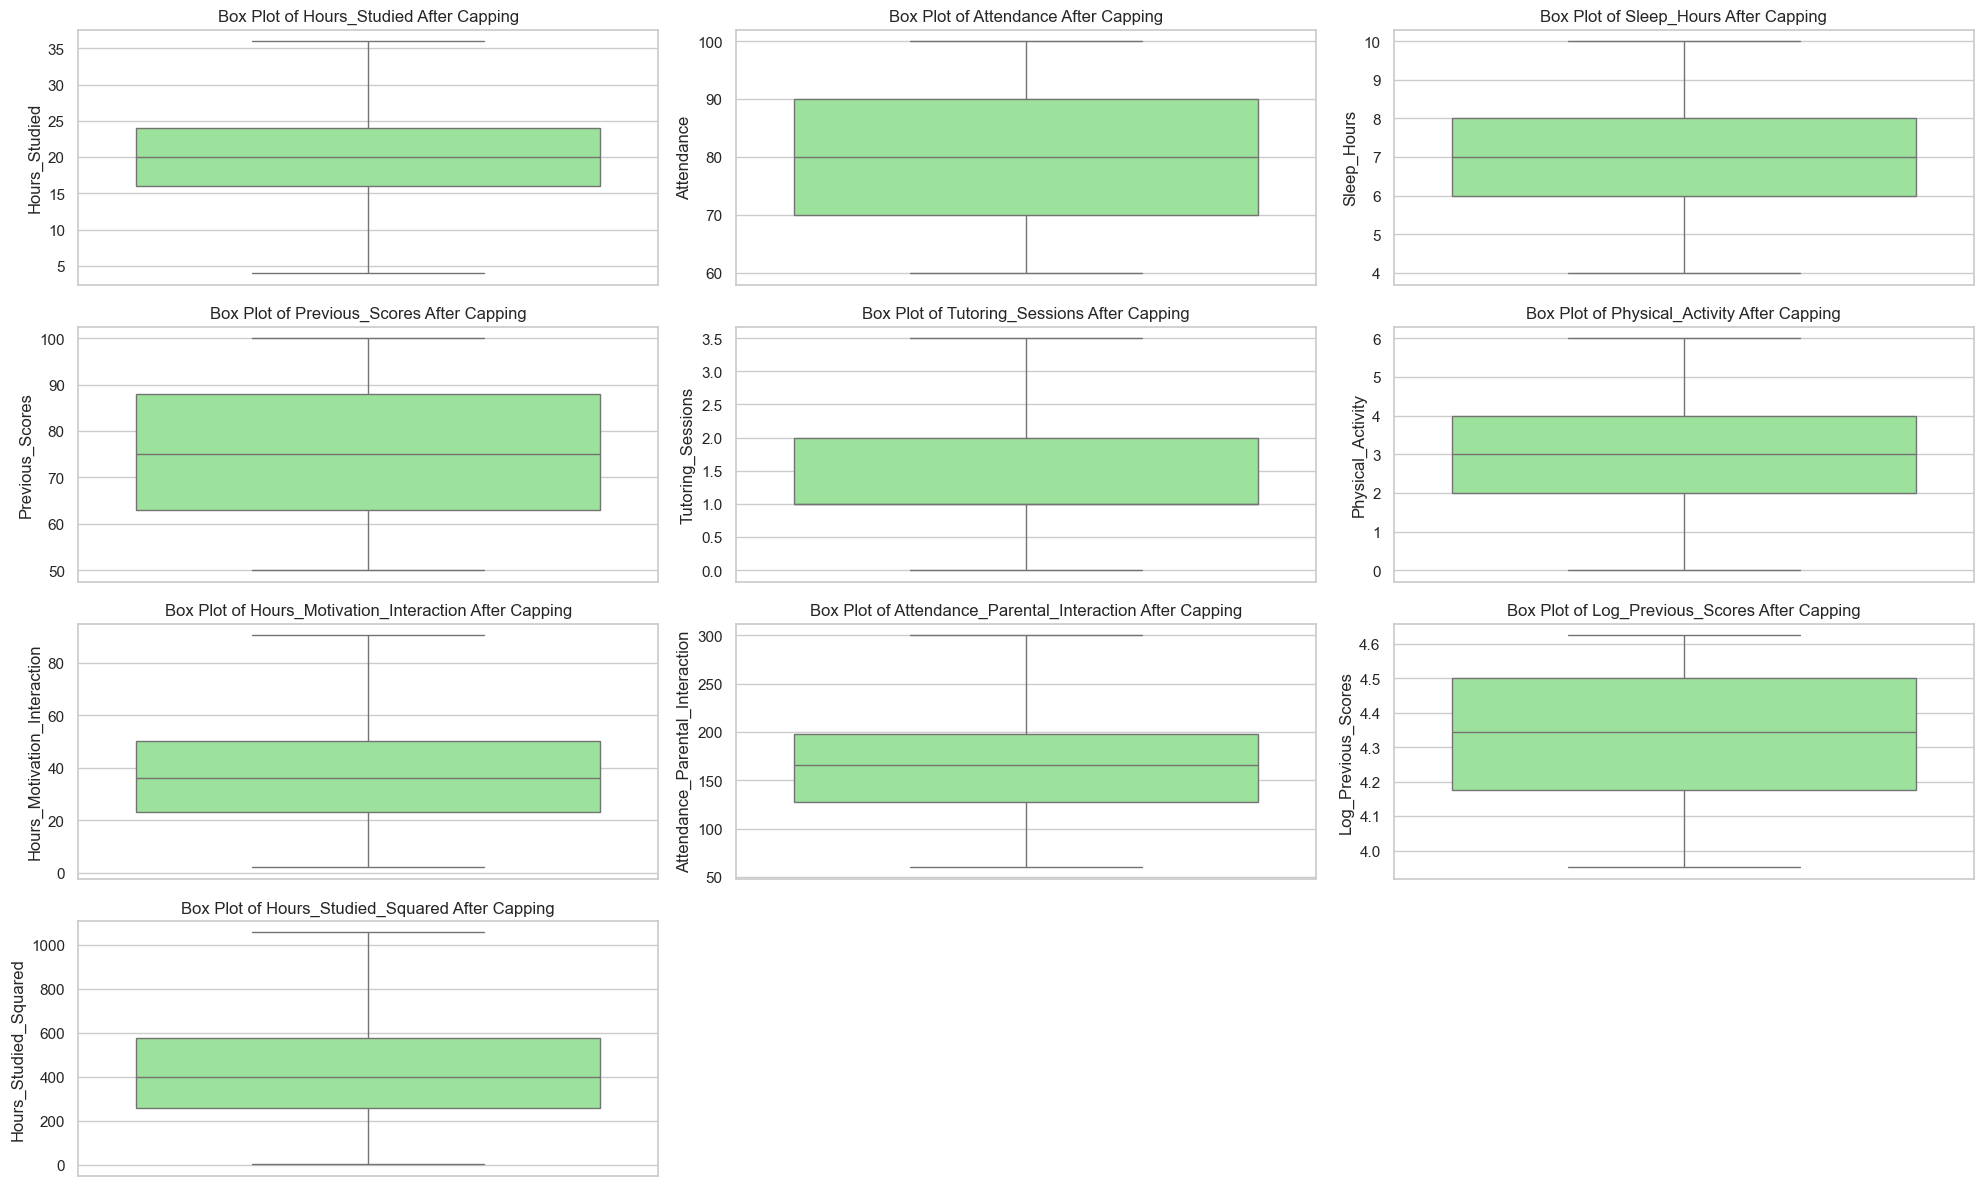

Descriptive Statistics After Outlier Handling:
       Hours_Studied   Attendance  Sleep_Hours  Previous_Scores  \
count    5102.000000  5102.000000  5102.000000      5102.000000   
mean       19.962368    80.002156     7.047432        75.052332   
std         5.964391    11.557744     1.467582        14.428953   
min         4.000000    60.000000     4.000000        50.000000   
25%        16.000000    70.000000     6.000000        63.000000   
50%        20.000000    80.000000     7.000000        75.000000   
75%        24.000000    90.000000     8.000000        88.000000   
max        36.000000   100.000000    10.000000       100.000000   

       Tutoring_Sessions  Physical_Activity  Hours_Motivation_Interaction  \
count        5102.000000        5102.000000                   5102.000000   
mean            1.430517           2.966876                     37.795276   
std             1.093154           1.034534                     18.001671   
min             0.000000           0.0000

In [64]:
# Plotting box plots after handling outliers
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(5, 3, i)
    sns.boxplot(y=X_train[feature], color='lightgreen')
    plt.title(f'Box Plot of {feature} After Capping')
plt.tight_layout()
plt.show()

# Checking Descriptive Statistics
print("Descriptive Statistics After Outlier Handling:")
print(X_train[numeric_features].describe())

#### Interpretation:
- **Reduced Whisker Lengths**: Indicate that outliers have been capped.
- **Enhanced Model Performance**: By mitigating extreme values, the model can generalize better without being disproportionately influenced by outliers.

In [65]:
pipeline.fit(X_train, y_train)

# Making predictions with the improved model
y_pred_improved = pipeline.predict(X_test)

# Calculating evaluation metrics for the improved model
mae_improved = mean_absolute_error(y_test, y_pred_improved)
mse_improved = mean_squared_error(y_test, y_pred_improved)
rmse_improved = np.sqrt(mse_improved)
r2_improved = r2_score(y_test, y_pred_improved)

print("Improved Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae_improved:.2f}")
print(f"Mean Squared Error (MSE): {mse_improved:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_improved:.2f}")
print(f"R² Score: {r2_improved:.2f}")

Improved Model Performance Metrics:
Mean Absolute Error (MAE): 0.69
Mean Squared Error (MSE): 4.44
Root Mean Squared Error (RMSE): 2.11
R² Score: 0.71
